## **Multi-Fidelity Gaussian Process**

In many engineering and physics modelling tasks, one may have data coming from not only a "high-fidelity" source of information, but also one or several sources of "low-fidelity" data. 

Typically, the high-fidelity data comes from some expensive processes such as long-running simulation codes, or real-world empirical experiments. This cost factor may render the collection of comprehensive training data for surrogate modelling to be impractical or impossible, such that only a few high-fidelity data samples exist. By contrast, low-fidelity data is typically generated from much cheaper (but much less accurate) processes. This means that low-fidelity data is plentiful, but often of limited usefulness for inference, since the data only correlates with the behaviour of the true process. 

In these scenarios, `twinlab` provides a number of multi-fidelity surrogate modelling approaches, which allows the user to model a surrogate of the high-fidelity process using only a small amount of high-fidelity data and a large amount of low-fidelity data.

This notebook will cover:
- Multi-fidelity Gaussian Process
- Multi-fidelity Gaussian Process with observation noise

In [2]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinlab imports
import twinlab as tl

import typeguard

{'username': 'jasper@digilab.co.uk', 'credits': 0}

         === TwinLab Client Initialisation ===
         Version  : 1.4.0
         User     : jasper@digilab.co.uk
         Server   : http://127.0.0.1:3000
         Key      : btUUe-IkGFOyuLun-HJAjg



### **Problem Formulation**

Here, we will formulate a true function from which we have a small amount of high-fidelity data, and another function which only correlates with the true function, but from which we can generate a large amount of low-fidelity data.

In particular, we will generate 10 training samples from the high-fidelity model, and 100 samples from the low-fidelity model. In reality, the ratio between the number of available samples of the high- and low-fidelity data may be much worse than a factor of 10.

In [3]:
# define high fidelity model with one output
def model(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

# define reduced fidelity model with one output
def reduced_model(x):
    return 0.5 * model(x) + 10 * (x - 0.5) + 5

X = np.linspace(0, 1)
y = model(X)
y_reduced = reduced_model(X)

# generate data
X_data = np.random.uniform(size=10)
y_data = model(X_data)

X_data_reduced = np.random.uniform(size=100)
y_data_reduced = reduced_model(X_data_reduced)

X_test = np.random.uniform(size=5)
y_test = model(X_test)

# generate fidelity data
data_fidelity = np.hstack((np.ones(10), 0.5 * np.ones(100), np.ones(5)))

# save to DataFrame
df = pd.DataFrame(
    {
        "x": np.hstack((X_data, X_data_reduced, X_test)),
        "y": np.hstack((y_data, y_data_reduced, y_test)),
        "fidelity": np.hstack((np.ones(10), 0.5 * np.ones(100), 1 * np.ones(5))),
    }
)

df.iloc[:20]

,x,y,fidelity
0,0.557202,0.793162,1.0
1,0.786339,-5.536153,1.0
2,0.086703,-0.396395,1.0
3,0.970312,14.285051,1.0
4,0.901835,5.970266,1.0
5,0.186829,-0.759176,1.0
6,0.223227,-0.422929,1.0
7,0.109333,-0.791523,1.0
8,0.003711,2.843427,1.0
9,0.558230,0.780222,1.0


**Note**: in order for the Gaussian Process model to be able to distinguish between which data sample is low- or high-fidelity, we have to include this information in the data table. In this case, we chose to call this column `'fidelity'`, and indicated the fidelity information by giving `fidelity=1.0` for high-fidelity data samples, and `fidelity=0.5` to indicate the low-fidelity data samples.

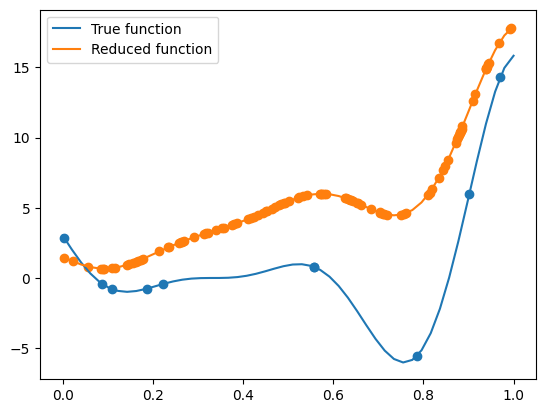

In [4]:
# Plot functions
plt.plot(X, y, label="True function", c="C0")
plt.scatter(X_data, y_data, c="C0")

plt.plot(X, y_reduced, label="Reduced function", c="C1")
plt.scatter(X_data_reduced, y_data_reduced, c="C1")

plt.legend()
plt.show()

In [5]:
# Upload dataframe
dataset_id = "FidelityGP_Data"

tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset FidelityGP_Data was processed.


### **Multifidelity GP Campaign**

In `twinlab`, a multifidelity GP model is exposed via the keyword argument `estimator_type="fixed_noise_gp"` provided to the `campaign_params` dictionary during initialisation. In addition, a `"fidelity"` keyword parameter at initialisation which denotes the name of the column containing the fidelity information is required. 

In [6]:
# Initialise campaign
campaign_id = "FidelityGP"

campaign_params = {
    "dataset_id": dataset_id,                   # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
    "fidelity": "fidelity",
    'estimator_kwargs': {
        'estimator_type': 'multi_fidelity_gp', # keyword string to request multifidelity model
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model FidelityGP has begun training.


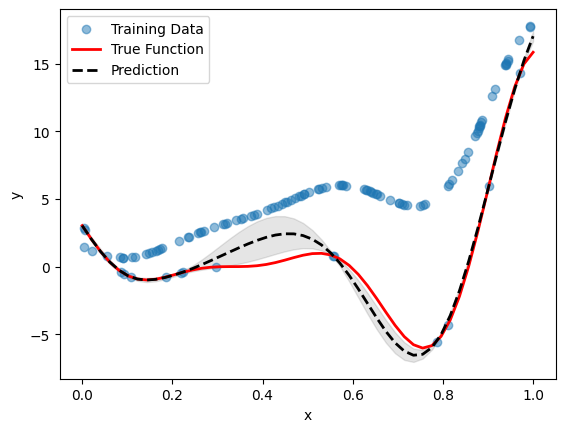

In [7]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

### **Multifidelity GP Campaign with homoskedastic noise**

In some instances, one may have observation noise associated with the data observations. In this case, one can still use a multi-fidelity model, however a new `DataFrame` called `df_stdev` must be provided to `tl.train_campaign`, containing the standard deviation of the observation noise/error. This additional table must contain the same columns as the mean data. Additionally, the key `'estimator_type': 'fixed_noise_multi_fidelity_gp'` should be provided to the `campaign_params` dictionary during initialisation.

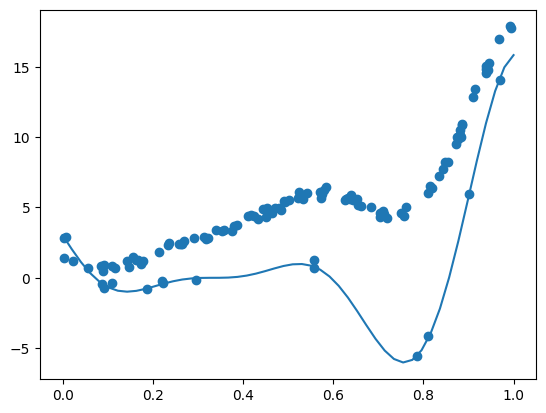

In [8]:
df_noisy = df.copy(deep=True)

# add noise to data
noise_scale = 0.2
df_noisy['y'] = df_noisy['y'] + np.random.normal(scale=noise_scale, size=len(df_noisy['y']))

# generate observation noise dataframe
df_stdev = pd.DataFrame({'y': np.ones(len(df_noisy['y']))*noise_scale})

plt.plot(X,y)
plt.scatter(df_noisy['x'].values, df_noisy['y'].values)
plt.show()

In [9]:
# Upload dataframes
dataset_id = "Noisy_FidelityGP_Data"

tl.upload_dataset(df_noisy, dataset_id, verbose=True)

dataset_std_id = "Noisy_FidelityGP_STD_Data"

tl.upload_dataset(df_stdev, dataset_std_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset Noisy_FidelityGP_Data was processed.
Dataframe is uploading.
Processing dataset.
Dataset Noisy_FidelityGP_STD_Data was processed.


In [10]:
# Initialise campaign
campaign_id = "ObsNoiseGP"

campaign_params = {
    "dataset_id": dataset_id,
    "dataset_std_id": dataset_std_id,
    "inputs": ['x'],                            
    "outputs": ['y'],
    "test_train_ratio": 0.75,                   
    "estimator": "gaussian_process_regression",
    'fidelity': 'fidelity',
    'estimator_kwargs': {
        'estimator_type': 'fixed_noise_multi_fidelity_gp', # keyword string to request homoskedastic model
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model ObsNoiseGP has begun training.


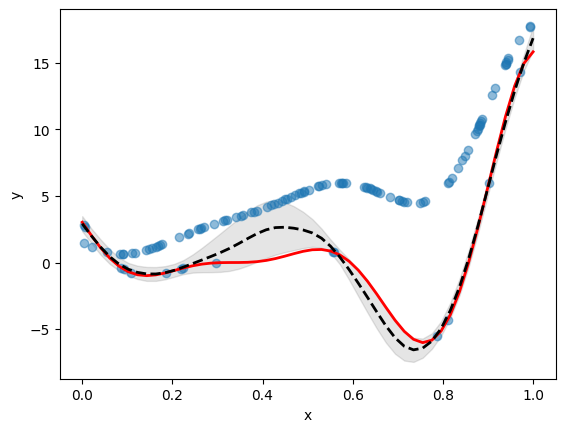

In [11]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2)
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed')
plt.show()

In [12]:
# Delete campaigns and dataset
tl.delete_campaign(campaign_id)
tl.delete_campaign("FidelityGP")

tl.delete_dataset(dataset_id)